# Pre-work steps

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter, MaxNLocator
from sklearn.linear_model import LinearRegression

In [ ]:
# Display Options
pd.set_option('display.min_rows', 25)
pd.set_option('display.max_rows', 100)
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

In [ ]:
# Color palette for plotting
color_palette = ['#B4D8B2', '#4572C5']

Stand-alone tables

In [ ]:
# orders_cleaned.csv
orders_cleaned = pd.read_csv('../data/cleaned/orders_cleaned.csv')

# orderlines_cleaned.csv
orderlines_cleaned = pd.read_csv('../data/cleaned/orderlines_cleaned.csv')

# products_categorized.csv
products_categorized = pd.read_csv('../data/cleaned/products_categorized.csv')

# brands_cleaned.csv
brands_clean = pd.read_csv('../data/cleaned/brands_cleaned.csv')

In [ ]:
# Copies of stand-alone DataFrames for manipulation
o_cl = orders_cleaned.copy()
ol_cl = orderlines_cleaned.copy()
p_cl = products_categorized.copy()
b_cl = brands_cleaned.copy()

In [ ]:
o_cl["created_date"] = pd.to_datetime(o_cl["created_date"])
ol_cl["date"] = pd.to_datetime(ol_cl["date"])

Merged tables

In [ ]:
# orderlines_products_df.csv
orderlines_products_df = pd.read_csv('../data/cleaned/orderlines_products_df.csv')

# products_brands_df.csv
products_brands_df = pd.read_csv('../data/cleaned/products_brands_df.csv')

In [ ]:
# Copies of merged DataFrames for manipulation
ol_p = orderlines_products_df.copy()
p_b = products_brands_df.copy()

In [ ]:
ol_p["date"] = pd.to_datetime(ol_p["date"])

In [ ]:
ol_p.info()

In [ ]:
# Merging the orderlines_products already merged table with the brands table (on 'sku' then replacing short/long for 'brand')
ol_p["brand"] = ol_p["sku"].str[:3]

ol_p_b = ol_p.merge(b_cl, how='left', left_on='brand', right_on='short')
ol_p_b.drop(['brand', 'short'], axis=1, inplace=True)
ol_p_b.rename(columns={'long': 'brand'}, inplace=True)

In [ ]:
# Adding orders to the ol_p_b merged tables to have all tables as one
all_tables = ol_p_b.merge(o_cl, how='left', left_on='id_order', right_on='order_id')

In [ ]:
all_tables["created_date"] = pd.to_datetime(all_tables["created_date"])

In [ ]:
all_tables.head()

In [ ]:
# Creating a new column for "delivery" (difference between total_paid and unit_price_total, which could be explained by delivery costs)
all_tables['delivery'] = all_tables['total_paid'] - all_tables['unit_price_total']

# Analyses

## New and calculated columns

In [ ]:
# Converting datetime to date (removing times) and adding additional columns ("quarter" and "year")
# all_tables["created_date"] = all_tables["created_date"].dt.date
all_tables["quarter"] = all_tables["created_date"].dt.quarter
all_tables["year"] = all_tables["created_date"].dt.year
all_tables["week"] = all_tables["created_date"].dt.isocalendar().week

# Positive "%_change" = % discount to customer; negative "%_change" = % gains
all_tables['%_change'] = ((all_tables['discount']) / all_tables['price'].replace(0, float('nan'))) * 100

In [ ]:
# Creating a calculated "price_total" column, using column "price" instead of "unit_price" (similar to the calculated "unit_price_total" column)
all_tables['price_total'] = all_tables['price'] * all_tables['product_quantity']

# Looking at the difference between price_total and unit_price_total
# (positive number=discount/loss to company, negative number=higher price/win for company)
all_tables['dif_base_price'] = all_tables['price_total'] - all_tables['unit_price_total']

In [ ]:
losses = all_tables[all_tables['dif_base_price'] > 0] # loss to company (earnings below "base" price)
gains = all_tables[all_tables['dif_base_price'] < 0] # gains to company (earnings above "base" price)

sum_losses = losses['dif_base_price'].sum()
sum_gains = gains['dif_base_price'].sum()

## Reorganized and selected columns

In [ ]:
all_tables = all_tables[['order_id','created_date','sku', 'in_stock', 'name', 'desc','brand','category','sub-category','condition','price','unit_price','discount','%_change','delivery','unit_price_total','total_paid','price_total','dif_base_price','product_quantity','quarter','year','week']]

In [ ]:
all_tables.head(2)

## What is the time period that the dataset covers?

In [ ]:
# The complete dataset date ranges = 2017-01-01 to 2018-03-14
all_tables["created_date"].min(), all_tables["created_date"].max()

In [ ]:
# Amount of time represented by the dataset? 437 days
all_tables["created_date"].max()- all_tables["created_date"].min()

## How many products are there?

In [ ]:
# 9992 products in total
p_cl['sku'].nunique()

In [ ]:
# 4537 unique products in 2017
# 2559 new products came in for 2018

# Grouping by 'year' and calculating the number of unique 'sku' (products)
unique_sku_by_year = all_tables.groupby('year')['sku'].nunique().reset_index()

# Rename 'sku' column for clarity
unique_sku_by_year.columns = ['year', 'unique_sku_count']
unique_sku_by_year

## What is the total revenue?

In [ ]:
# Revenue being calculated as gross income
# for our dataset ='total_paid', as it includes the shipment/delivery costs, and the completed orders('state'=="Completed")

In [ ]:
# Total revenue for the time covered in the dataset= 11,803,686.56 Euros
all_tables["total_paid"].sum().round(2)

In [ ]:
# Total revenue for onlt 2017 = 9,417,271.82 Euros, and for only 2018 (3+ months only)= 2,386,414.74 Euros
all_tables.groupby('year')['total_paid'].sum()

## What are the most sold products?

In [ ]:
all_tables.groupby(['sku','name','category','sub-category'])['product_quantity'].sum().nlargest(10).reset_index()

## What are the products that generate the most revenue?

In [ ]:
(
all_tables.groupby(['order_id','sku','name','category', 'sub-category','price','discount','unit_price','product_quantity'])
['total_paid'].sum().nlargest(10).reset_index()
)

## Does revenue grow whenever discounts increase?

In [ ]:
# Short answer: after a certain point, "no"
# This did not seem to make a difference by year, although in 2017 the company was able to charge more than base price
# in 2017 higher prices ("earnings" compared to base price) make up for some of the discounts?!
sns.relplot(data=all_tables,
            x="discount",
            y="total_paid",
            hue="year",
            height=7,
            aspect=1.5,
            palette=color_palette)

In [ ]:
# Opened packages receive the highest discounts (looking at complete dataset, 1+ years)
sns.relplot(data=all_tables,
            x="discount",
            y="total_paid",
            hue="condition",
            height=7,
            aspect=1.5,
            palette=color_palette)

In [ ]:
# Specific categories sell more when discounted AND opened but does not bring a higher revenue (except for laptops)
# Looking at complete dataset, 1 years and 3.5 months
sns.relplot(data=all_tables,
            x="discount",
            y="total_paid",
            hue="condition",
            col="category",
            palette=color_palette,
            col_wrap=3)

In [ ]:
# Opened iMacs and iPhones that are opened receive the greatest discounts from all sub-categories
sns.relplot(data=all_tables,
            x="discount",
            y="total_paid",
            hue="condition",
            col="sub-category",
            palette=color_palette,
            col_wrap=3)

## Development of orders and revenue over time

The board reported "an increase in orders placed but decrease in total revenue". What does a longer-term trend look like?




### Evolution of total orders over time (quarters) - 2017 vs 2018

In [ ]:
grouped_data_orders = all_tables.groupby(['quarter','year']).size().reset_index(name='order_count')

In [ ]:
# 2018 Q1 sales were lower than 2017 Q4, BUT, they were higher than 2017 Q1
# Positive trend in sales increasing

# Define a formatter function for the y-axis
def yaxis_format(tick, pos):
    return f'{tick / 1000:.1f} T'  # Divide by 1000 and add "T"

# Create the plot
catplot = sns.catplot(
    data=grouped_data_orders,
    x="quarter",
    y="order_count",
    hue="year",
    kind="bar",
    palette=color_palette,
    aspect=2,  # Make the plot wider
    height=6   # Adjust the height
)

# Format the y-axis
catplot.ax.yaxis.set_major_formatter(FuncFormatter(yaxis_format))

# Add title and axis labels
plt.title("Orders Count by Quarters in 2017 and 2018")
plt.ylabel("Completed Orders")
plt.xlabel("Quarters")

# Show the plot
plt.show()

### Evolution of revenue over time (quarters) - 2017 vs 2018

In [ ]:
grouped_data_revenue= all_tables.groupby(['quarter', 'year'])['total_paid'].sum().reset_index(name='total_revenue')

In [ ]:
# 2018 Q1 revenue was lower than in 2017 Q4, BUT, revenue was higher than in 2017 Q1
# Positive trend in revenue development

sns.catplot(
    data=grouped_data_revenue,
    x="quarter",
    y="total_revenue",
    hue="year",
    kind="bar",
    palette=color_palette,
    aspect=2,  # Make the plot wider
    height=6   # Adjust the height
)

# Customizing the y-axis formatting
ax = plt.gca()  # Get the current axis
#ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('€{x:,.0f}'))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'€{x/1e6:.1f}M'))

# Adding titles to show in plot
plt.title("Total Revenue by Quarters in 2017 and 2018")
plt.ylabel("Total Revenue (Euros)")
plt.xlabel("Quarters")
plt.show()

### Seasons and sales

Are there seasonal patterns in the evolution of orders completed? (any periods of highest orders completed/peaks, vs lowest orders completed/valleys?)

In [ ]:
grouped_data_dates_orders = all_tables.groupby(['week','year']).size().reset_index(name='order_count')

In [ ]:
sns.catplot(data=grouped_data_dates_orders,
            x="week",
            y="order_count",
            hue="year",
            kind="bar",
            palette=color_palette,
            height=6,
            aspect=2)

plt.title("Orders Count by Weeks in 2017 and 2018")
plt.ylabel("Completed Orders")
plt.xlabel("Weeks")
plt.show()

### Seasons and revenue

Are there seasonal patterns in the evolution of sales? (any periods of highest sales/peaks, vs lowest sales/valleys?)

In [ ]:
grouped_data_dates_revenue = all_tables.groupby(['week','year'])['total_paid'].sum().reset_index(name='total_revenue')

In [ ]:
# Monthly Revenue Aggregation
ol_p['month'] = ol_p['date'].dt.month
monthly_revenue = ol_p.groupby('month')['unit_price_total'].sum()

# Weekly Revenue Bar Chart
sns.set(style="white")
plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_revenue.index, y=monthly_revenue.values, marker='o', color='skyblue')

# Add titles and axis labels
plt.title('Monthly revenue', fontsize=16)
plt.xlabel('Monthly of the year', fontsize=12)
plt.ylabel('Total revenue', fontsize=12)

# Show plot
plt.show()

In [ ]:
# Weekly Revenue Aggregation
ol_p['week'] = ol_p['date'].dt.isocalendar().week
weekly_revenue = ol_p.groupby('week')['unit_price_total'].sum()

# Weekly Revenue Bar Chart
sns.set(style="white")
plt.figure(figsize=(12, 6))
sns.lineplot(x=weekly_revenue.index, y=weekly_revenue.values, marker='o', color='skyblue')

# Add titles and axis labels
plt.title('Weekly revenue', fontsize=16)
plt.xlabel('Week of the year', fontsize=12)
plt.ylabel('Total revenue', fontsize=12)

# Show plot
plt.show()

In [ ]:
# Filter orders for Christmas
# christmas_period = ol_p[(ol_p['date'].dt.month == 11) & (ol_p['date'].dt.day >= 30) & (ol_p['date'].dt.month == 12) & (ol_p['date'].dt.day <= 23)]

# Total sales during Christmas
# christmas_revenue = christmas_period['unit_price_total'].sum()

# Total revenue over the whole year
# total_revenue = ol_p['unit_price_total'].sum()

# Calculate the revenue share of Christmas
# christmas_revenue_percentage = (christmas_revenue / total_revenue) * 100
# print(f"Share of sales from Christmas: {christmas_revenue_percentage:.2f}%")

# Assumption: Black Friday falls on the last Friday in November
# black_friday = ol_p[ol_p['date'].dt.month == 11]
# black_friday = black_friday[black_friday['date'].dt.weekday == 4]

# black_friday_revenue = black_friday['unit_price_total'].sum()

# Calculate Black Friday's revenue share
# black_friday_revenue_percentage = (black_friday_revenue / total_revenue) * 100
# print(f"Share of sales from Black Friday: {black_friday_revenue_percentage:.2f}%")

### Products & categories on Christmas & Black friday

In [ ]:
# Filter for Christmas
christmas_data = ol_p[(ol_p['date'] >= '2017-12-20') & (ol_p['date'] <= '2017-12-26')]

# Christmas analysis
# Frequently sold Products at Christmas
christmas_top_products = (
    christmas_data.groupby('name')['product_quantity']
    .sum()
    .sort_values(ascending=False)
)
# Sales per category at Christmas
christmas_revenue_by_category = (
    christmas_data.groupby('category')['unit_price_total']
    .sum()
    .sort_values(ascending=False)
)

print("Top 10 products for christmas:")
print(christmas_top_products.nlargest(10))

print("\nRevenue per Category for christmas:")
print(christmas_revenue_by_category.nlargest(10))

In [ ]:
# Filter for Black-Friday
black_friday_data = ol_p[(ol_p['date'] >= '2017-11-01') & (ol_p['date'] <= '2017-11-30')]

# Black-Friday
# Frequently Sold Products at Black Friday
black_friday_top_products = (
    black_friday_data.groupby('name')['product_quantity']
    .sum()
    .sort_values(ascending=False)
)

# Sales per category at Black Friday
black_friday_revenue_by_category = (
    black_friday_data.groupby('category')['unit_price_total']
    .sum()
    .sort_values(ascending=False)
)

print("\nTop 10 products Black Friday:")
print(black_friday_top_products.nlargest(10))

print("\nRevenue per Category Black Friday:")
print(black_friday_revenue_by_category.nlargest(10))

In [ ]:
sns.catplot(
    data=grouped_data_dates_revenue,
    x="week",
    y="total_revenue",
    hue="year",
    kind="bar",
    #palette=color_palette,
    palette=['#D9D9D9','#A6A6A6'],
    height=6,
    aspect=2
)

# Customizing the y-axis formatting
ax = plt.gca()  # Get the current axis
#ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('€{x:,.0f}'))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'€{x/1e6:.1f}M'))

# Adding titles to show in plot
plt.title("Revenue by Weeks in 2017 and 2018")
plt.ylabel("Revenue (Euros)")
plt.xlabel("Weeks")
plt

## Discounts

In [ ]:
# How many products are being discounted?
count_products_discounted = ol_p['discount'] > 0
count_products_discounted.count()

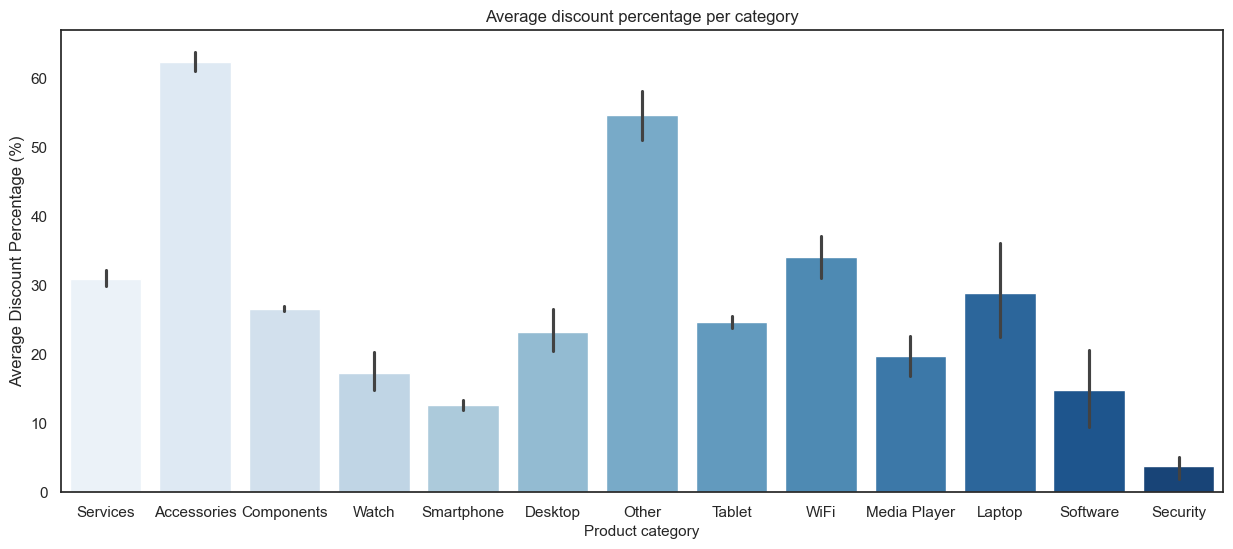

In [156]:
# Calculate the discount percentage for each row
ol_p['discount_percentage'] = (ol_p['discount'] / ol_p['unit_price']) * 100
all_tables['discount_percentage'] = (all_tables['discount'] / all_tables['unit_price']) * 100

# Average discount per product category
plt.figure(figsize=(15, 6))

sns.set(style="white")
sns.barplot(x='category', y='discount_percentage', data=ol_p, hue='category', palette='Blues', legend=False)

# Add titles and axis labels
plt.title('Average discount percentage per category', fontsize=12)
plt.xlabel('Product category', fontsize=11)
plt.ylabel('Average Discount Percentage (%)', fontsize=12)

# Show plot
# plt.xticks(rotation=45)  # Rotation of x-axis labels
plt.show()

In [ ]:
# Average discount per brand
# plt.figure(figsize=(15, 6))

# sns.set(style="white")
# sns.barplot(x='brand', y='discount_percentage', data=all_tables, hue='brand', palette='Blues', legend=False)

# Add titles and axis labels
# plt.title('Average discount percentage per brand', fontsize=14)
# plt.xlabel('Product brand', fontsize=12)
# plt.ylabel('Average Discount Percentage (%)', fontsize=12)

# Show plot
# plt.xticks(rotation=45)  # Rotation of x-axis labels
# plt.show()

### How do seasonality and special dates (Christmas, Black Friday) affect sales?

In [ ]:
# Monthly Revenue Aggregation
ol_p['month'] = ol_p['date'].dt.month
monthly_revenue = ol_p.groupby('month')['unit_price_total'].sum()

# Monthly Revenue Bar Chart
plt.figure(figsize=(10, 6))
sns.set(style="white")
sns.barplot(x=monthly_revenue.index, y=monthly_revenue.values, hue=monthly_revenue.index, palette='Blues', legend=False)

# Add titles and axis labels
plt.title('Monthly revenue', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total revenue', fontsize=12)

# Show plot
plt.show()

### Products being discounted in 2017

In [ ]:
discounts_2017 = all_tables[all_tables['year'] == 2017]

In [ ]:
# Amount of products being discounted (or not) in the year 2017 are as follows:
# 1649 products were not discounted
no_discounts = discounts_2017['discount'] == 0
no_discounts.sum()

In [ ]:
# 1393 products were being charged more than base price
above_base_price = discounts_2017['discount'] < 0
above_base_price.sum()

In [ ]:
# 38923 products are discounted
discounted = discounts_2017['discount'] > 0
discounted.sum()

### Losses ("discounts") versus gains

In [ ]:
# Variables and figures based on codes under section above "New and calculated columns"
# sum_losses"= amount total below base price (when product was sold for less than base price, =total of discounts)
# sum_gains"= amount total above base price (when product was sold for more than base price, =total of gains)

# Filtering for rows where the year is 2017
losses_2017 = losses[losses['year'] == 2017]
gains_2017 = gains[gains['year'] == 2017]

# Calculating the sum of 'dif_base_price' for the filtered data
sum_losses_2017 = losses_2017['dif_base_price'].sum()
sum_gains_2017 = gains_2017['dif_base_price'].sum()

sum_losses_2017, sum_gains_2017
# in Euros: 1,228,888.29 - 28,511.98

In [ ]:
# 2017 difference = 1,200,376.31 ("losses" in Euros to the company in 2017)
1228888.29 - 28511.98

In [ ]:
all_tables.head(1)

### Evolution of losses (discounts) and gains (sales above base price) over time

Looking at the evolution over time (year 2017 in weeks) of company's revenue comparing how much the products **could have sold** for if sold at base price ("price_total") versus how much they **actually sold** for ("unit_price_total").  Products sold below base price are seen as a "loss" to the company, whereas products sold above base price are seen as gains.

In [ ]:
# Define a custom formatter
def my_formatter(x, pos):
    return f'{x / 1000:.1f}k'

fig, ax = plt.subplots()
ax.plot([1000, 2000, 3000, 4000], [1, 2, 3, 4])

# Apply the custom formatter
ax.yaxis.set_major_formatter(FuncFormatter(my_formatter))
plt.show()

In [ ]:
# Plotting shows peaks in sales when more discounts were offered!! Discounts are a good thing for the company!!!!!

# Custom formatting of the y-axis to show amounts by the thousands (1,000 = 1K)
def thousands_formatter(x, pos):
    return f'{int(x / 1000)}k'

# Aggregate unit_price_total and price_total by week and year
all_tables_aggregated = all_tables.groupby(['year', 'week'])[['unit_price_total', 'price_total']].sum().reset_index()

# Filter for the year 2017
all_tables_2017 = all_tables_aggregated[all_tables_aggregated['year'] == 2017]

all_tables_melted_2017 = all_tables_2017.melt(
    id_vars='week',
    value_vars=['unit_price_total', 'price_total'],
    var_name='Category',
    value_name='Value'
)

# Adjusting plot's width and height
plt.figure(figsize=(14, 8))

# Customizing legend names (custom names for the "categories")
custom_labels = {'unit_price_total': 'Sold Price', 'price_total': 'Base Price'}
all_tables_melted_2017['Category'] = all_tables_melted_2017['Category'].replace(custom_labels)

# Ploting the data
sns.lineplot(
    data=all_tables_melted_2017,
    x='week',
    y='Value',
    #style='Category',
    #marker='o',
    hue='Category',
    #palette=['green', 'blue'],
    palette=color_palette)

# Setting all weeks as x-axis ticks
weeks = sorted(all_tables_melted_2017['week'].unique())
plt.xticks(weeks, labels=[f'{week}' for week in weeks])

# Applying custom formatting to the y-axis
# plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Customizing the y-axis formatting
ax = plt.gca()  # Get the current axis
# ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('€{x:,.0f}'))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'€{x/1e6:.1f}M'))

# Adding titles and labels
plt.title('Effects of Discounts on Sales (2017)', fontsize=16)
plt.xlabel('Weeks)', fontsize=14)
plt.ylabel('Revenue (€)', fontsize=14)
plt.legend(title='', bbox_to_anchor=(0.13, .99))

# Printing the plot
plt.show()

In [ ]:
# Adding trend lines makes it even clearer that the greater the discounts, the greater the sales revenues
# again, discounts are a good thing for company!!!!!

# Custom formatting of the y-axis to show amounts by the thousands (1,000 = 1K)
def thousands_formatter(x, pos):
    return f'{int(x / 1000)}k'

# Customizing legend names (custom names for the "categories")
custom_labels = {'unit_price_total': 'Sold Price', 'price_total': 'Base Price'}
all_tables_melted_2017['Category'] = all_tables_melted_2017['Category'].replace(custom_labels)

# Adjusting plot's width and height
plt.figure(figsize=(18, 8))

# Defining color as palette
# palette = {'Sold Price': 'green', 'Base Price': 'blue'}
palette = {'Sold Price': '#B4D8B2', 'Base Price': '#4572C5'}
# palette=color_palette

# Plotting the data (deactivating "style" means keeping only solid lines)
sns.lineplot(
    data=all_tables_melted_2017,
    x='week',
    y='Value',
   # style='Category',
    hue='Category',
    palette=palette,
    marker=None,
)

# Calculating and plotting trend lines for each category
categories = all_tables_melted_2017['Category'].unique()
for category in categories:
    # Filtering data
    category_data = all_tables_melted_2017[all_tables_melted_2017['Category'] == category]

    # Performing linear regression
    x = category_data['week']
    y = category_data['Value']
    trend = np.polyfit(x, y, deg=1)
    trend_line = np.polyval(trend, x)

    # Plotting the trend line with matching color
    plt.plot(x, trend_line, linestyle=':', color=palette[category], label=f'{category} Trend', alpha=0.7)

# Setting all weeks as x-axis ticks
weeks = sorted(all_tables_melted_2017['week'].unique())
plt.xticks(weeks, labels=[f'{week}' for week in weeks])

# Applying custom formatting to the y-axis
# plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Customizing the y-axis formatting
ax = plt.gca()  # Get the current axis
#ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('€{x:,.0f}'))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'€{x/1e6:.1f}M'))

# Adding titles and labels
plt.title('Effects of Discounts on Sales (2017)', fontsize=16)
plt.xlabel('Weeks', fontsize=14)
plt.ylabel('Revenue (€)', fontsize=14)

# Adjusting the legend box
plt.legend(bbox_to_anchor=(0.09, 0.9), loc='center')

# Printing the plot
plt.show()

In [ ]:
# For 2018 the trend of higher discounts=higher sales continues from 2018, although looking at the first quarter only shows a negative trend line.
# This negative trend line is comparative to 2017's when high sales from end of the year started to taper down.
# It can be assumed that in 2018 trend lines will be similar to those in 2017.
# One can also expect sales to be better in 2018 given the comparison from q1 2018 vs q1 2017 already shows an improvement

# Filter for the year 2018
all_tables_2018 = all_tables_aggregated[all_tables_aggregated['year'] == 2018]

all_tables_melted_2018 = all_tables_2018.melt(
    id_vars='week',
    value_vars=['unit_price_total', 'price_total'],
    var_name='Category',
    value_name='Value'
)

# Custom formatting of the y-axis to show amounts by the thousands (1,000 = 1K)
def thousands_formatter(x, pos):
    return f'{int(x / 1000)}k'

# Customizing legend names (custom names for the "categories")
custom_labels = {'unit_price_total': 'Sold Price', 'price_total': 'Base Price'}
all_tables_melted_2018['Category'] = all_tables_melted_2018['Category'].replace(custom_labels)

# Adjusting plot's width and height
plt.figure(figsize=(14, 8))

# Defining color as palette
palette = {'Sold Price': 'green', 'Base Price': 'blue'}

# Plotting the data (deactivating "style" means keeping only solid lines)
sns.lineplot(
    data=all_tables_melted_2018,
    x='week',
    y='Value',
   # style='Category',
    hue='Category',
    #palette=palette,
    palette=color_palette,
    marker=None
)

# Calculating and plotting trend lines for each category
categories = all_tables_melted_2018['Category'].unique()
for category in categories:
    # Filtering data
    category_data = all_tables_melted_2018[all_tables_melted_2018['Category'] == category]

    # Performing linear regression
    x = category_data['week']
    y = category_data['Value']
    trend = np.polyfit(x, y, deg=1)
    trend_line = np.polyval(trend, x)

    # Plotting the trend line with matching color
    plt.plot(x, trend_line, linestyle=':', color=palette[category], label=f'{category} Trend', alpha=0.7)

# Setting all weeks as x-axis ticks
weeks = sorted(all_tables_melted_2018['week'].unique())
plt.xticks(weeks, labels=[f'{week}' for week in weeks])

# Applying custom formatting to the y-axis
# plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))

# Applying custom formatting to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Adding titles and labels
plt.title('Effects of Discounts on Sales (2018)', fontsize=16)
plt.xlabel('Weeks', fontsize=14)
plt.ylabel('Revenue (€)', fontsize=14)

# Adjusting the legend box
plt.legend(bbox_to_anchor=(0.09, 0.9), loc='center')

# Printing the plot
plt.show()

### Seasons and discounts

In [ ]:
grouped_data_dates_discounts = all_tables.groupby(['week','year','%_change','price','unit_price'])['%_change'].mean().reset_index(name='total_revenue')

sns.catplot(
    data=grouped_data_dates_discounts,
    x="week",
    y="%_change",
    hue="year",
    kind="bar",
    height=6,
    aspect=2,
    #palette=['green', 'blue'],
    palette=color_palette,
    errorbar=None,
)

# Adding titles to show in plot
plt.title("Discounts by Weeks in 2017 and 2018")
plt.ylabel("Discount %")
plt.xlabel("Weeks")
plt

### Relationship between amount of products sold and discount %

In [ ]:
# Discounts seem to make a difference in how many products are sold only during special seasons (i.e. black friday and xmas)
# Discounts do not seem to make a difference any other time of the year

# When wanting to see plotting by condition "opened" (or "new"):
# filtered_data = all_tables[(all_tables['year'] == 2017) & (all_tables['condition'] == 'Opened')]

# Filter data to include only rows where the year is 2017
filtered_data = all_tables[all_tables['year'] == 2017]

# Group data by 'week' to calculate averages
weekly_data = filtered_data.groupby('week').agg(
    avg_percentage_change=('%_change', 'mean'),
    avg_product_quantity=('product_quantity', 'sum')
).reset_index()

# Set up the figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the average percentages per week on the primary y-axis
sns.lineplot(
    data=weekly_data,
    x='week',
    y='avg_percentage_change',
    #marker='o',
    ax=ax1,
    #color='blue',
    color='#4572C5',
    label='% Discount'
)

# Customize the primary y-axis
ax1.set_ylabel('% Discount', fontsize=12,
               color='blue',
               #color='#4572C5'
               )
ax1.tick_params(axis='y',
                labelcolor='blue',
                #labelcolor='#4572C5'
                )
ax1.set_xlabel('Weeks', fontsize=12)
ax1.set_xticks(weekly_data['week'])
ax1.set_xticklabels(weekly_data['week'])

# Create a secondary y-axis for the average product quantity
ax2 = ax1.twinx()
sns.lineplot(
    data=weekly_data,
    x='week',
    y='avg_product_quantity',
    #marker='o',
    ax=ax2,
    #color='green',
    color='#B4D8B2',
    label='Products Sold'
)

# Customize the secondary y-axis
ax2.set_ylabel('Products Sold', fontsize=12, color='green')
ax2.tick_params(axis='y', labelcolor='green',
                #labelcolor='#B4D8B2'
                )

# Add a title
plt.title('Weekly Trends in 2017: % Discounts and Products Sold (Weekly averages)', fontsize=14)

# Adjust layout and show the plot
fig.tight_layout()
plt.show()

### Relationship between order size and discounts

In [ ]:
# There does not seem to be a relationship betwween discount % and how many products are ordered/ordered size
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

# Group by week and order_id to calculate weekly average products per order
avg_products_per_order = (
    filtered_data.groupby(['week', 'order_id'])['product_quantity']
    .sum()
    .groupby('week')
    .mean()
    .reset_index(name='avg_products_per_order')
)

# Merge with weekly_data for combined plotting
weekly_data = filtered_data.groupby('week').agg(
    avg_percentage_change=('%_change', 'mean')
).reset_index()
weekly_data = weekly_data.merge(avg_products_per_order, on='week')

# Set up the figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary axis plot
sns.lineplot(
    data=weekly_data,
    x='week',
    y='avg_percentage_change',
    ax=ax1,
    #color='blue',
    color='#4572C5',
    label='% Discount'
)
ax1.set_ylabel('% Discount', fontsize=12, color='blue')
ax1.tick_params(axis='y',
                labelcolor='blue',
                #labelcolor='#4572C5'
                )

# Secondary axis plot
ax2 = ax1.twinx()
sns.lineplot(
    data=weekly_data,
    x='week',
    y='avg_products_per_order',
    ax=ax2,
    #color='green',
    color='#B4D8B2',
    label='Avg Products per Order'
)
ax2.set_ylabel('Avg Products per Order', fontsize=12, color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))  # Force whole numbers

# Add title and finalize layout
plt.title('Weekly Trends in 2017: % Discounts and Avg Products per Order', fontsize=14)
fig.tight_layout()
plt.legend(loc='upper left')
plt.show()


In [ ]:
# Step 1: Calculate the average of the '%_change' column
average_discount = all_tables['%_change'].mean()

# Step 2: Group by 'category' and calculate the average '%_change'
grouped_avg_discount = all_tables.groupby('category')['%_change'].mean()

# Step 3: Filter data where 'condition' is 'Opened'
filtered_weekly_data = all_tables[all_tables['condition'] == 'Opened']

# Step 4: Aggregate the data by 'week'
weekly_data = filtered_weekly_data.groupby('week').agg(
    avg_percentage_change=('%_change', 'mean'),
    avg_products_per_order=('product_quantity', 'mean')
).reset_index()

# Step 5: Prepare data for trend lines
X_weeks = weekly_data['week'].values.reshape(-1, 1)

# Step 6: Calculate the trend line for Discount Percentage
discount_model = LinearRegression()
discount_model.fit(X_weeks, weekly_data['avg_percentage_change'])
weekly_data['discount_trend'] = discount_model.predict(X_weeks)

# Step 7: Calculate the trend line for Avg Products per Order
products_model = LinearRegression()
products_model.fit(X_weeks, weekly_data['avg_products_per_order'])
weekly_data['products_trend'] = products_model.predict(X_weeks)

# Step 8: Set up the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot for % Discount on primary axis
sns.lineplot(
    data=weekly_data,
    x='week',
    y='avg_percentage_change',
    ax=ax1,
    #color='blue',
    color='#4572C5',
    label='% Discount'
)
sns.lineplot(
    data=weekly_data,
    x='week',
    y='discount_trend',
    ax=ax1,
    #color='blue',
    color='#4572C5',
    linestyle='--',
    label='Discount Trend'
)
ax1.set_ylabel('% Discount', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot for Avg Products per Order on secondary axis
ax2 = ax1.twinx()
sns.lineplot(
    data=weekly_data,
    x='week',
    y='avg_products_per_order',
    ax=ax2,
    #color='green',
    color='#B4D8B2',
    label='Avg Products per Order'
)
sns.lineplot(
    data=weekly_data,
    x='week',
    y='products_trend',
    ax=ax2,
    #color='green',
    color='#B4D8B2',
    linestyle='--',
    label='Products Trend'
)
ax2.set_ylabel('Avg Products per Order', fontsize=12, color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

# Step 9: Adjust x-axis and finalize layout
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Weekly Trends: % Discounts and Avg Products per Order (Condition: Open)', fontsize=14)
fig.tight_layout()

# Step 10: Show legend and plot
plt.legend(loc='upper left')
plt.show()


### Discount % according to category and condition ("New" or "Opened")

In [ ]:
# Opened items get the highest discount % which might pull the avg across new and opened

# Filter data to include only rows where the year is 2017
filtered_data = all_tables[all_tables['year'] == 2017]

# Group data by 'week', 'categories', and 'condition' to calculate averages
grouped_data = (
    filtered_data.groupby(['week', 'category', 'condition'])
    .agg(
        avg_percentage_change=('%_change', 'mean'),
        avg_product_quantity=('product_quantity', 'sum')
    )
    .reset_index()
)

palette = {'New': 'green','Opened': 'blue'}

# Set up a FacetGrid to create subplots for each category
g = sns.FacetGrid(
    grouped_data,
    col="category",
    col_wrap=3,  # Adjust to control the number of columns in the grid
    height=4,
    sharex=True,
    sharey=False
)

# Add line plots for avg_percentage_change (primary y-axis)
g.map_dataframe(
    sns.lineplot,
    x="week",
    y="avg_percentage_change",
    hue="condition",
    #palette=palette,
    palette=color_palette
)
g.set_axis_labels("Week", "% Discount")
g.set_titles("{col_name}")
g.add_legend(title="Condition")

# Customize the layout and show the plot
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Weekly Trends in 2017 by Categories: % Discount and Condition")
plt.show()